# PROJECT LUNG DISEASES

## REQUIREMENT

In [1]:
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG19, InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, f1_score
import itertools

## DATA PREP

In [2]:
! pip install -q kaggle
from google.colab import files
#upload kaggle.json API akun pribadi
files.upload()
# make directory for save the dataset
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
# Import dataset from kaggle to colab
! kaggle datasets download -d anjay007/penyakit-paru-paru-5-kelas

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/anjay007/penyakit-paru-paru-5-kelas
License(s): CC0-1.0
 96% 268M/280M [00:02<00:00, 119MB/s]
100% 280M/280M [00:02<00:00, 124MB/s]


In [3]:
! unzip  /content/penyakit-paru-paru-5-kelas.zip -d lung_disease/
#menghapus zip file dataset
!rm -r /content/penyakit-paru-paru-5-kelas.zip
#menghapus zip file dataset
!rm -r /content/kaggle.json

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: lung_disease/train_dir/bacterial_pneumonia/person26_bacteria_132.jpeg  
  inflating: lung_disease/train_dir/bacterial_pneumonia/person26_bacteria_133.jpeg  
  inflating: lung_disease/train_dir/bacterial_pneumonia/person27_bacteria_135.jpeg  
  inflating: lung_disease/train_dir/bacterial_pneumonia/person27_bacteria_136.jpeg  
  inflating: lung_disease/train_dir/bacterial_pneumonia/person27_bacteria_137.jpeg  
  inflating: lung_disease/train_dir/bacterial_pneumonia/person29_bacteria_144.jpeg  
  inflating: lung_disease/train_dir/bacterial_pneumonia/person2_bacteria_3.jpeg  
  inflating: lung_disease/train_dir/bacterial_pneumonia/person30_bacteria_147.jpeg  
  inflating: lung_disease/train_dir/bacterial_pneumonia/person30_bacteria_148.jpeg  
  inflating: lung_disease/train_dir/bacterial_pneumonia/person30_bacteria_149.jpeg  
  inflating: lung_disease/train_dir/bacterial_pneumonia/person30_bacteria_150.jpeg  
  inflati

### Initiation Directory

In [4]:
#Path dataset
BASE_DIR = '/content/lung_disease/Lung Disease Dataset'

#Path train, test, dan validation
train = '/content/lung_disease/train_dir'
val = '/content/lung_disease/test_dir'

### Datagenerator

In [5]:
# Membuat objek ImageDataGenerator untuk augmentasi data pada set pelatihan
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.05,
    rotation_range=180,
    width_shift_range=0.1,
    height_shift_range=0.1)

# Membuat objek ImageDataGenerator untuk preprocessing pada set pengujian dan validasi
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Menggunakan objek ImageDataGenerator untuk memuat data gambar dari direktori dan melakukan augmentasi
train_generator = train_datagen.flow_from_directory(
    train,
    target_size=(224, 224),
    class_mode='categorical',  # Mode kelas untuk klasifikasi banyak kelas
    batch_size = 16,
    shuffle=True
)

val_generator = test_val_datagen.flow_from_directory(
    val,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size = 8,
    shuffle=True
)


Found 6080 images belonging to 5 classes.
Found 982 images belonging to 5 classes.


## TRAINNING W RESNET50

### Load pretrined CNN

In [ ]:
# Memuat model ResNet50 tanpa layer teratas (top layer)
resnet_model = ResNet50(weights='imagenet',
                        include_top=False,
                        input_shape=(224, 224, 3))
for layer in resnet_model.layers:
    layer.trainable = False
model_resnet = Sequential()
model_resnet.add(resnet_model)
model_resnet.add(Dense(256,activation='relu'))
model_resnet.add(Dropout(0.2))
model_resnet.add(Dense(768,activation='relu'))
model_resnet.add(Dropout(0.2))
model_resnet.add(Flatten())
model_resnet.add(Dense(train_generator.num_classes,
                       activation='softmax'))
print(model_resnet.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 dense_3 (Dense)             (None, 7, 7, 256)         524544    
                                                                 
 dropout_2 (Dropout)         (None, 7, 7, 256)         0         
                                                                 
 dense_4 (Dense)             (None, 7, 7, 768)         197376    
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 768)         0         
                                                                 
 flatten (Flatten)           (None, 37632)             0         
                                                                 
 dense_5 (Dense)             (None, 5)                

In [ ]:
# Compile model
model_resnet.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['acc'])
class CustomCallback(tf.keras.callbacks.Callback):
    total_above_target = 0
    def on_epoch_end(self, epoch, logs=None):
        if logs["val_acc"] > 0.90 and logs["acc"] > 0.88:
            self.total_above_target += 1
            if self.total_above_target > 3:
                self.model.stop_training = True
callback = CustomCallback()
# Train model
history = model_resnet.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=callback
)

Epoch 1/30
380/380 [==============================] - 131s 324ms/step - loss: 1.6526 - acc: 0.2289 - val_loss: 1.5785 - val_acc: 0.1558
Epoch 2/30
380/380 [==============================] - 120s 316ms/step - loss: 1.5648 - acc: 0.2878 - val_loss: 1.5173 - val_acc: 0.3106
Epoch 3/30
380/380 [==============================] - 103s 270ms/step - loss: 1.5054 - acc: 0.3428 - val_loss: 1.4622 - val_acc: 0.3360
Epoch 4/30
380/380 [==============================] - 103s 271ms/step - loss: 1.4483 - acc: 0.3791 - val_loss: 1.3695 - val_acc: 0.4430
Epoch 5/30
380/380 [==============================] - 101s 266ms/step - loss: 1.3838 - acc: 0.4183 - val_loss: 1.3179 - val_acc: 0.4593
Epoch 6/30
380/380 [==============================] - 102s 267ms/step - loss: 1.3241 - acc: 0.4452 - val_loss: 1.3010 - val_acc: 0.4389
Epoch 7/30
380/380 [==============================] - 101s 267ms/step - loss: 1.2574 - acc: 0.4694 - val_loss: 1.1997 - val_acc: 0.4868
Epoch 8/30
380/380 [============================

In [ ]:
#model_resnet.save("resnet_model.h5")
#with open('history_resnet.txt', mode='w') as file:
#    file.write(str(history.history['acc'])+'/n'+str(history.history['loss']))
#    file.close()

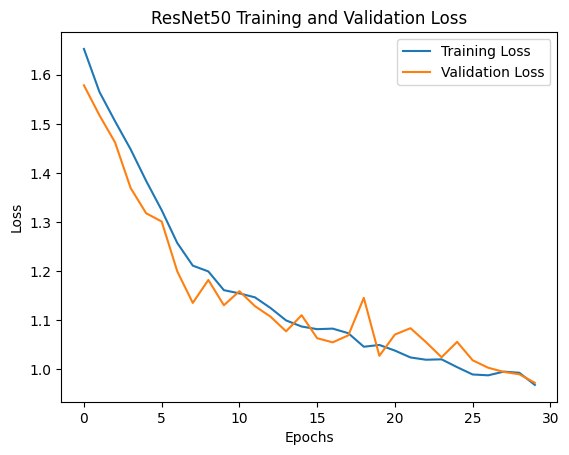

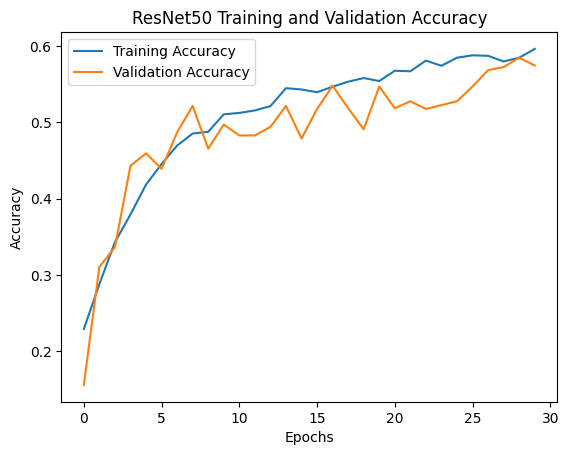

In [ ]:
# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('ResNet50 Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.title('ResNet50 Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
results = model_resnet.evaluate(val_generator)

print("Loss:", results[0])
print("Accuracy:", results[1])

123/123 [==============================] - 6s 52ms/step - loss: 0.9725 - acc: 0.5743
Loss: 0.9724963307380676
Accuracy: 0.5743380784988403


In [ ]:
train_predictions = model_resnet.predict(train_generator, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_generator.classes

train_class_report = classification_report(train_true_labels,
                                          train_predicted_labels, target_names=train_generator.class_indices,
                                          digits=5)
print("\nResNet50 Training classification report:\n", train_class_report)



380/380 [==============================] - 94s 242ms/step

ResNet50 Training classification report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.19563   0.15410   0.17240      1220
            covid19    0.21674   0.28962   0.24793      1243
             normal    0.20021   0.15466   0.17451      1235
       tuberculosis    0.19444   0.17949   0.18667      1170
    viral_pneumonia    0.18820   0.22112   0.20334      1212

           accuracy                        0.20016      6080
          macro avg    0.19904   0.19980   0.19697      6080
       weighted avg    0.19917   0.20016   0.19718      6080



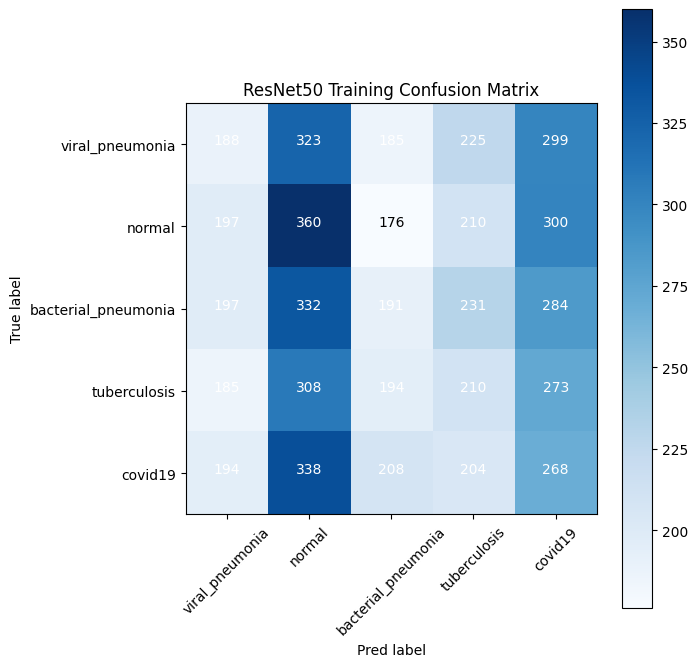

In [ ]:
inp = '/content/lung_disease'
classes = []
filename = inp
for sub_folder in os.listdir(os.path.join(filename, 'train_dir')):
    classes.append(sub_folder)
# print(classes)
classname_label = classes
train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(7, 7))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("ResNet50 Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

## TRAINNING W VGG19


### Load Pretrained CNN

In [6]:
VGG19_model =VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers
for layer in VGG19_model.layers:
    layer.trainable = False
#Membuat model
model_VGG19 = Sequential()
model_VGG19.add(VGG19_model)
model_VGG19.add(Dense(256,activation='relu'))
model_VGG19.add(Dropout(0.2))
model_VGG19.add(Dense(768,activation='relu'))
model_VGG19.add(Dropout(0.2))
model_VGG19.add(Flatten())
model_VGG19.add(Dense(train_generator.num_classes, activation='softmax'))

print(model_VGG19.summary())

80134624/80134624 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 dense (Dense)               (None, 7, 7, 256)         131328    
                                                                 
 dropout (Dropout)           (None, 7, 7, 256)         0         
                                                                 
 dense_1 (Dense)             (None, 7, 7, 768)         197376    
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 768)         0         
                                                                 
 flatten (Flatten)           (None, 37632)             0         
                                                         

In [7]:
# Compile model
model_VGG19.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['acc'])
class CustomCallback(tf.keras.callbacks.Callback):
    total_above_target = 0
    def on_epoch_end(self, epoch, logs=None):
        if logs["val_acc"] > 0.90 and logs["acc"] > 0.88:
            self.total_above_target += 1
            if self.total_above_target > 3:
                self.model.stop_training = True
callback = CustomCallback()
# Train model
history_VGG19 = model_VGG19.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=callback
)

Epoch 1/30
380/380 [==============================] - 124s 304ms/step - loss: 1.2373 - acc: 0.4865 - val_loss: 0.8724 - val_acc: 0.6650
Epoch 2/30
380/380 [==============================] - 101s 265ms/step - loss: 0.8338 - acc: 0.6590 - val_loss: 0.7969 - val_acc: 0.6853
Epoch 3/30
380/380 [==============================] - 103s 271ms/step - loss: 0.7188 - acc: 0.7117 - val_loss: 0.7821 - val_acc: 0.6629
Epoch 4/30
380/380 [==============================] - 101s 267ms/step - loss: 0.6742 - acc: 0.7188 - val_loss: 0.6948 - val_acc: 0.7210
Epoch 5/30
380/380 [==============================] - 102s 268ms/step - loss: 0.6403 - acc: 0.7428 - val_loss: 0.6752 - val_acc: 0.7251
Epoch 6/30
380/380 [==============================] - 102s 268ms/step - loss: 0.6112 - acc: 0.7533 - val_loss: 0.6523 - val_acc: 0.7464
Epoch 7/30
380/380 [==============================] - 100s 263ms/step - loss: 0.5808 - acc: 0.7676 - val_loss: 0.5548 - val_acc: 0.7831
Epoch 8/30
380/380 [============================

In [ ]:
# model_VGG19.save("VGG19_model_skenario1.h5")
# with open('history_VGG19.txt', mode='w') as file:
#    file.write(str(history_VGG19.history['acc'])+'/n'+str(history_VGG19.history['loss']))
#    file.close()

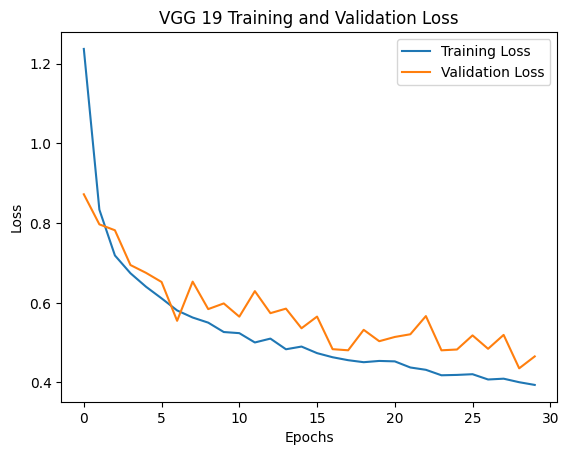

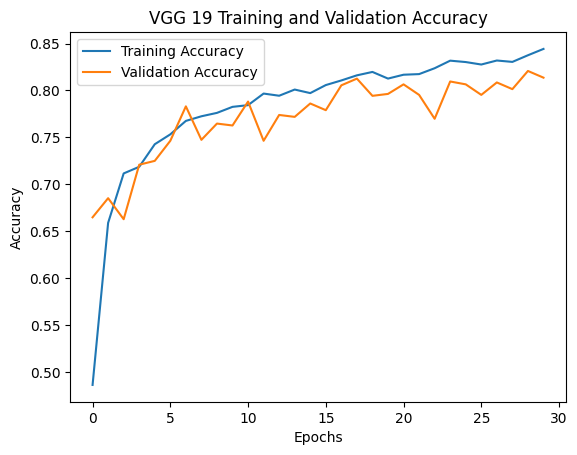

In [8]:
# Plot loss
plt.plot(history_VGG19.history['loss'], label='Training Loss')
plt.plot(history_VGG19.history['val_loss'], label='Validation Loss')
plt.title('VGG 19 Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_VGG19.history['acc'], label='Training Accuracy')
plt.plot(history_VGG19.history['val_acc'], label='Validation Accuracy')
plt.title('VGG 19 Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [9]:
results = model_VGG19.evaluate(val_generator)

print("Loss:", results[0])
print("Accuracy:", results[1])

123/123 [==============================] - 8s 62ms/step - loss: 0.4655 - acc: 0.8136
Loss: 0.4654501676559448
Accuracy: 0.813645601272583


In [10]:
train_predictions = model_VGG19.predict(train_generator, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_generator.classes

train_class_report = classification_report(train_true_labels,
                                          train_predicted_labels, target_names=train_generator.class_indices,
                                          digits=5)
print("\nVGG 19 Training classification report:\n", train_class_report)



380/380 [==============================] - 92s 240ms/step

VGG 19 Training classification report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.19965   0.18770   0.19349      1220
            covid19    0.19888   0.19952   0.19920      1243
             normal    0.18695   0.18785   0.18740      1235
       tuberculosis    0.17848   0.17863   0.17856      1170
    viral_pneumonia    0.17818   0.18729   0.18262      1212

           accuracy                        0.18832      6080
          macro avg    0.18843   0.18820   0.18825      6080
       weighted avg    0.18856   0.18832   0.18838      6080



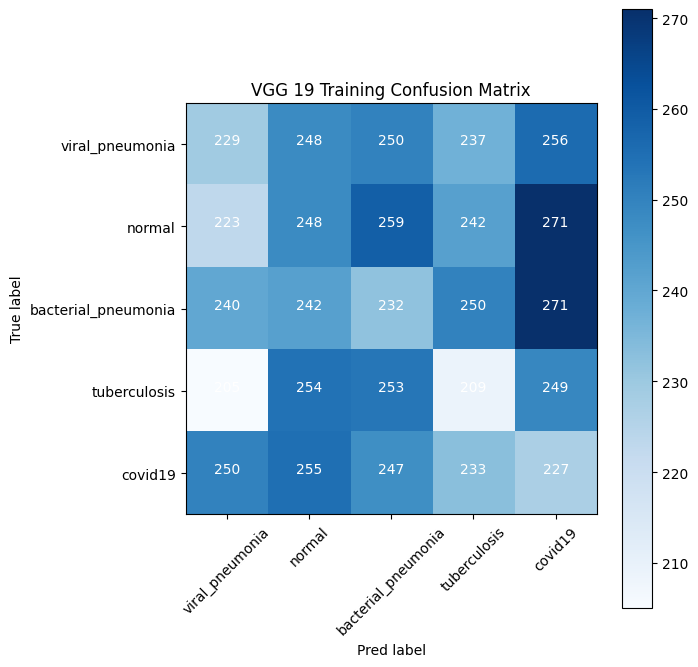

In [11]:
inp = '/content/lung_disease'
classes = []
filename = inp
for sub_folder in os.listdir(os.path.join(filename, 'train_dir')):
    classes.append(sub_folder)
# print(classes)
classname_label = classes
train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(7, 7))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("VGG 19 Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

## TRAINNING W InceptionV3


### Load Pretrained CNN

In [12]:
InceptionV3_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers
for layer in InceptionV3_model.layers:
    layer.trainable = False
#Membuat model
model_InceptionV3 = Sequential()
model_InceptionV3.add(InceptionV3_model)
model_InceptionV3.add(Dense(256,activation='relu'))
model_InceptionV3.add(Dropout(0.2))
model_InceptionV3.add(Dense(768,activation='relu'))
model_InceptionV3.add(Dropout(0.2))
model_InceptionV3.add(Flatten())
model_InceptionV3.add(Dense(train_generator.num_classes, activation='softmax'))

print(model_InceptionV3.summary())

87910968/87910968 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 dense_3 (Dense)             (None, 5, 5, 256)         524544    
                                                                 
 dropout_2 (Dropout)         (None, 5, 5, 256)         0         
                                                                 
 dense_4 (Dense)             (None, 5, 5, 768)         197376    
                                                                 
 dropout_3 (Dropout)         (None, 5, 5, 768)         0         
                                                                 
 flatten_1 (Flatten)         (None, 19200)             0         
                                                       

In [13]:
# Compile model
model_InceptionV3.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['acc'])
class CustomCallback(tf.keras.callbacks.Callback):
    total_above_target = 0
    def on_epoch_end(self, epoch, logs=None):
        if logs["val_acc"] > 0.90 and logs["acc"] > 0.88:
            self.total_above_target += 1
            if self.total_above_target > 3:
                self.model.stop_training = True
callback = CustomCallback()
# Train model
history_InceptionV3 = model_InceptionV3.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=callback,
)

Epoch 1/30
380/380 [==============================] - 107s 263ms/step - loss: 0.9374 - acc: 0.6074 - val_loss: 0.7819 - val_acc: 0.6701
Epoch 2/30
380/380 [==============================] - 96s 251ms/step - loss: 0.6813 - acc: 0.7138 - val_loss: 0.8119 - val_acc: 0.6395
Epoch 3/30
380/380 [==============================] - 96s 252ms/step - loss: 0.5916 - acc: 0.7594 - val_loss: 0.6679 - val_acc: 0.7077
Epoch 4/30
380/380 [==============================] - 96s 253ms/step - loss: 0.5530 - acc: 0.7707 - val_loss: 0.6881 - val_acc: 0.6833
Epoch 5/30
380/380 [==============================] - 95s 250ms/step - loss: 0.5319 - acc: 0.7850 - val_loss: 0.7055 - val_acc: 0.7149
Epoch 6/30
380/380 [==============================] - 94s 247ms/step - loss: 0.5101 - acc: 0.7878 - val_loss: 0.6128 - val_acc: 0.7434
Epoch 7/30
380/380 [==============================] - 95s 250ms/step - loss: 0.4849 - acc: 0.7985 - val_loss: 0.6006 - val_acc: 0.7485
Epoch 8/30
380/380 [==============================] - 

In [ ]:
#model_InceptionV3.save("InceptionV3_model.h5")
#with open('history_InceptionV3.txt', mode='w') as file:
#    file.write(str(history_InceptionV3.history['acc'])+'/n'+str(history_InceptionV3.history['loss']))
#    file.close()

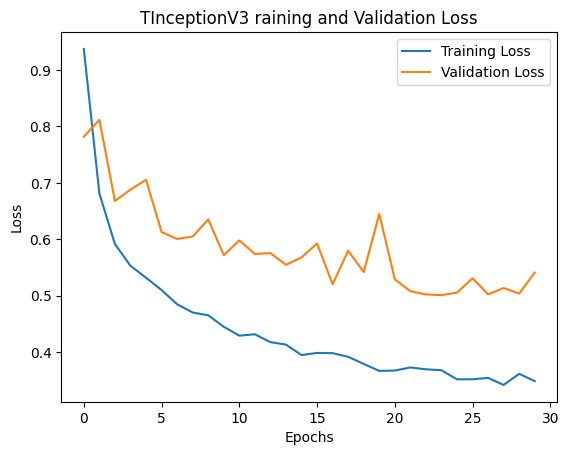

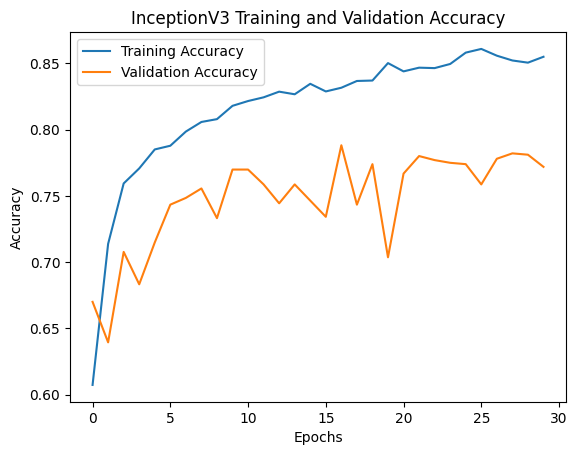

In [14]:
# Plot loss
plt.plot(history_InceptionV3.history['loss'], label='Training Loss')
plt.plot(history_InceptionV3.history['val_loss'], label='Validation Loss')
plt.title('TInceptionV3 raining and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_InceptionV3.history['acc'], label='Training Accuracy')
plt.plot(history_InceptionV3.history['val_acc'], label='Validation Accuracy')
plt.title('InceptionV3 Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [15]:
results = model_InceptionV3.evaluate(val_generator)

print("Loss:", results[0])
print("Accuracy:", results[1])

123/123 [==============================] - 5s 38ms/step - loss: 0.5410 - acc: 0.7719
Loss: 0.5410303473472595
Accuracy: 0.771894097328186


In [16]:
train_predictions = model_InceptionV3.predict(train_generator, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_generator.classes

train_class_report = classification_report(train_true_labels,
                                          train_predicted_labels, target_names=train_generator.class_indices,
                                          digits=5)
print("\nInceptionV3 Training classification report:\n", train_class_report)



380/380 [==============================] - 91s 235ms/step

InceptionV3 Training classification report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.19249   0.23115   0.21006      1220
            covid19    0.19665   0.21722   0.20642      1243
             normal    0.21253   0.20324   0.20778      1235
       tuberculosis    0.19533   0.17863   0.18661      1170
    viral_pneumonia    0.18971   0.15512   0.17068      1212

           accuracy                        0.19737      6080
          macro avg    0.19734   0.19707   0.19631      6080
       weighted avg    0.19740   0.19737   0.19649      6080



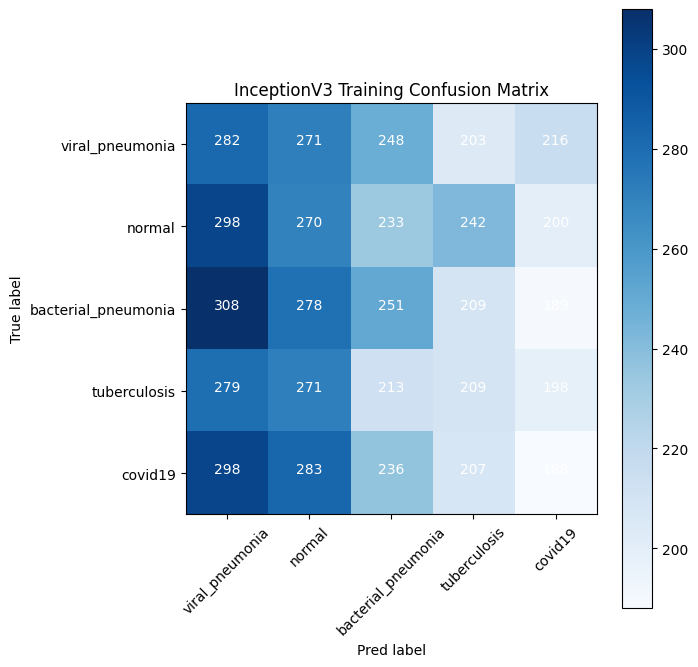

In [17]:
inp = '/content/lung_disease'
classes = []
filename = inp
for sub_folder in os.listdir(os.path.join(filename, 'train_dir')):
    classes.append(sub_folder)
# print(classes)
classname_label = classes
train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(7, 7))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("InceptionV3 Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()